### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)

### Set working directory

In [2]:
# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

# Change working directory
os.chdir('/Users/tyler/OneDrive/Documents/Python/NBA')

# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

Directory: C:\Users\tyler\OneDrive\Documents\Python\NBA\backend\predictions
Directory: C:\Users\tyler\OneDrive\Documents\Python\NBA


## Exploratory Data Analysis

### Import data

In [3]:
totals_df = pd.read_csv('backend/data/totals/game_totals.csv').drop(['Unnamed: 0'], axis=1)[['date', 'visitor', 'home', '3p']]
predict_df = pd.read_csv('backend/predictions/3p_predictions.csv').drop(['Unnamed: 0'], axis=1)

# Convert date to datetime
totals_df['date'] = pd.to_datetime(totals_df['date'])
predict_df['date'] = pd.to_datetime(predict_df['date'])

# Total 3pt by both teams
totals_df = totals_df.groupby(['date', 'visitor', 'home']).sum()

# Merge datafrtames
df = pd.merge(predict_df, totals_df, left_on=['date', 'visitor', 'home'], right_on=['date', 'visitor', 'home'], how='left')
df = df.drop_duplicates(['date', 'visitor', 'home']).dropna(axis=0)

# Seperate current games from past games
today_df = df[df['3p'] == 0]
df = df[df['3p'] > 0]

# Day of week
df['dow_name'] = df['date'].dt.day_name()

# Sort by date 
df = df.sort_values(['date'], ascending=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 311
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              298 non-null    datetime64[ns]
 1   visitor           298 non-null    object        
 2   home              298 non-null    object        
 3   linear            298 non-null    int64         
 4   decision_tree     298 non-null    int64         
 5   gradient_boosted  298 non-null    int64         
 6   neural_network    298 non-null    int64         
 7   random_forest     298 non-null    int64         
 8   line              298 non-null    float64       
 9   avg               298 non-null    float64       
 10  over              298 non-null    float64       
 11  under             298 non-null    float64       
 12  3p                298 non-null    float64       
 13  dow_name          298 non-null    object        
dtypes: datetime64[ns](1), floa

## Feauture Engineer Model's Perforamnces

In [4]:
def myround(x, base=.5):
    return base * round(x/base)

In [5]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
for model in models:
    df[model + '_predict'] = np.where(df[model] > df['line'], 'o', 'u')
    
    # Compute if model predicted correctly
    df[model + '_hit'] = ((df['3p'] > df['line']) & (df[model] > df['line'])) | \
                            ((df['3p'] < df['line']) & (df[model] < df['line']))
    
    # Compute models profit per bet
    df[model + '_potential_profit'] = np.where(df[model] > df['line'], df['over'], df['under'])
    
    df[model + '_potential_profit'] = np.where(
        df[model + '_potential_profit'] > 0, df[model + '_potential_profit'] / 100, -100 / df[model + '_potential_profit'])
    
    df[model + '_profit'] = np.where(df[model + '_hit'], df[model + '_potential_profit'], -1)
    
    # Compute difference between line and prediction
    df[model + '_diff'] = myround(df[model] - df['line'])
    
    # Compute accumulative profit overtime
    df[model + '_accumulative_profit'] = df[model + '_profit'].cumsum()

df.tail()

,date,visitor,home,linear,decision_tree,gradient_boosted,neural_network,random_forest,line,avg,over,under,3p,dow_name,linear_predict,linear_hit,linear_potential_profit,linear_profit,linear_diff,linear_accumulative_profit,decision_tree_predict,decision_tree_hit,decision_tree_potential_profit,decision_tree_profit,decision_tree_diff,decision_tree_accumulative_profit,gradient_boosted_predict,gradient_boosted_hit,gradient_boosted_potential_profit,gradient_boosted_profit,gradient_boosted_diff,gradient_boosted_accumulative_profit,neural_network_predict,neural_network_hit,neural_network_potential_profit,neural_network_profit,neural_network_diff,neural_network_accumulative_profit,random_forest_predict,random_forest_hit,random_forest_potential_profit,random_forest_profit,random_forest_diff,random_forest_accumulative_profit,avg_predict,avg_hit,avg_potential_profit,avg_profit,avg_diff,avg_accumulative_profit
310,2022-04-06,Phoenix Suns,Los Angeles Clippers,25,23,24,26,24,24.5,24.4,-105.0,-130.0,29.0,Wednesday,o,True,0.952381,0.952381,0.5,-15.518615,u,False,0.769231,-1.000000,-1.5,10.686285,u,False,0.769231,-1.000000,-0.5,-4.623471,o,True,0.952381,0.952381,1.5,-8.623626,u,False,0.769231,-1.000000,-0.5,14.807600,u,False,0.769231,-1.000000,-0.0,3.315482
306,2022-04-06,Boston Celtics,Chicago Bulls,23,23,23,25,24,24.5,23.6,105.0,-145.0,24.0,Wednesday,u,True,0.689655,0.689655,-1.5,-14.828959,u,True,0.689655,0.689655,-1.5,11.375940,u,True,0.689655,0.689655,-1.5,-3.933816,o,False,1.050000,-1.000000,0.5,-9.623626,u,True,0.689655,0.689655,-0.5,15.497255,u,True,0.689655,0.689655,-1.0,4.005137
307,2022-04-06,Brooklyn Nets,New York Knicks,26,25,26,27,25,24.5,25.8,-115.0,-115.0,27.0,Wednesday,o,True,0.869565,0.869565,1.5,-13.959394,o,True,0.869565,0.869565,0.5,12.245505,o,True,0.869565,0.869565,1.5,-3.064251,o,True,0.869565,0.869565,2.5,-8.754060,o,True,0.869565,0.869565,0.5,16.366820,o,True,0.869565,0.869565,1.5,4.874703
308,2022-04-06,Dallas Mavericks,Detroit Pistons,26,26,26,27,26,24.5,26.2,-105.0,-125.0,26.0,Wednesday,o,True,0.952381,0.952381,1.5,-13.007013,o,True,0.952381,0.952381,1.5,13.197886,o,True,0.952381,0.952381,1.5,-2.111870,o,True,0.952381,0.952381,2.5,-7.801680,o,True,0.952381,0.952381,1.5,17.319201,o,True,0.952381,0.952381,1.5,5.827084
311,2022-04-06,Washington Wizards,Atlanta Hawks,24,24,24,24,25,24.5,24.2,115.0,-160.0,26.0,Wednesday,u,False,0.625000,-1.000000,-0.5,-14.007013,u,False,0.625000,-1.000000,-0.5,12.197886,u,False,0.625000,-1.000000,-0.5,-3.111870,u,False,0.625000,-1.000000,-0.5,-8.801680,o,True,1.150000,1.150000,0.5,18.469201,u,False,0.625000,-1.000000,-0.5,4.827084


# Model's

### Day of week profit over time

,dow_name,random_forest_profit
1,Monday,15.043963
0,Friday,12.253920
6,Wednesday,5.457877
5,Tuesday,2.178381
4,Thursday,-1.578119
2,Saturday,-3.228145
3,Sunday,-11.658676


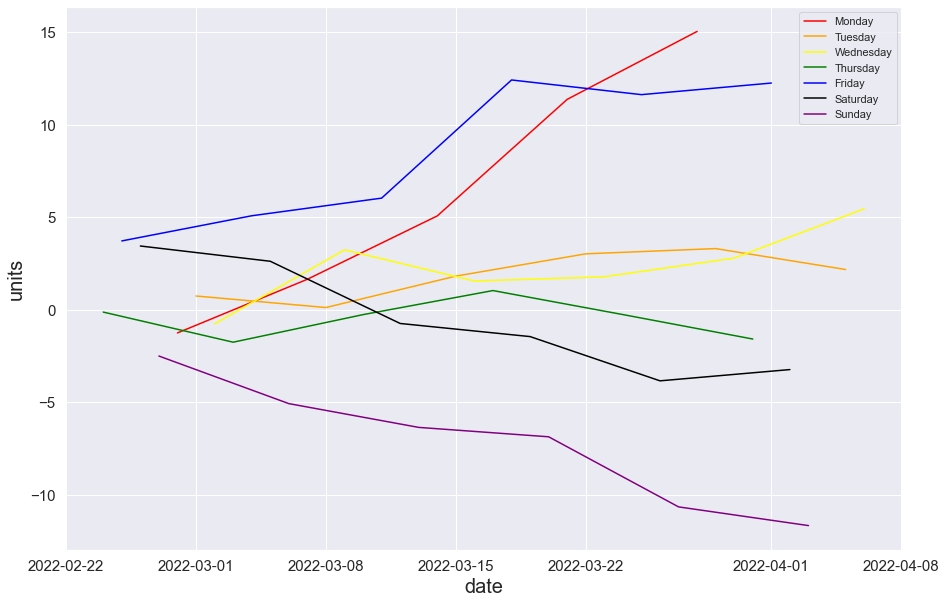

In [6]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
sns.set_palette('bright', 8)
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black', 'purple']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day, color in zip(days, colors):
    dow_df = df.groupby(['date', 'dow_name']).aggregate('sum').reset_index()
    dow_df = dow_df[dow_df['dow_name'] == day]
    dow_df['profit'] = dow_df['random_forest_profit'].cumsum()
    
    sns.lineplot(data=dow_df, x='date', y='profit', color=color, label=day)


dow_df = df.groupby(['dow_name']).aggregate('sum').reset_index().sort_values(['random_forest_profit'], ascending=False)
dow_df[['dow_name', 'random_forest_profit']]

### Profit Analysis

,model,record,accuracy,profit
4,random_forest,175 - 123,59,18.47
1,decision_tree,172 - 126,58,12.20
5,avg,169 - 129,57,4.83
2,gradient_boosted,165 - 133,55,-3.11
3,neural_network,160 - 138,54,-8.80
0,linear,159 - 139,53,-14.01


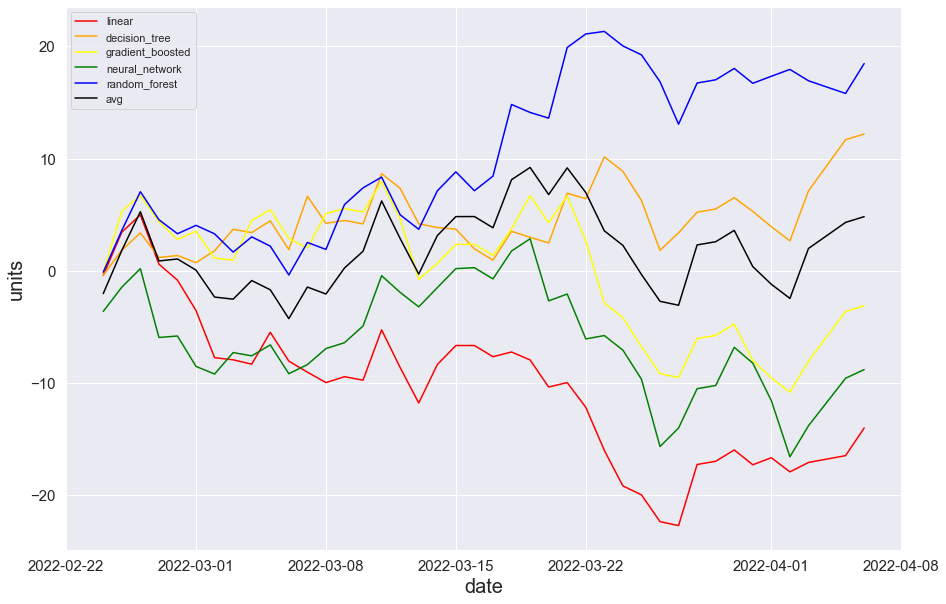

In [7]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Totals
totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}


colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(data=df.groupby(['date']).sum(), x='date', y=df.groupby(['date']).sum()[f'{model}_profit'].cumsum(), color=col, label=model)
    
    # Totals
    profit = df[model + '_profit'].sum()
    correct = df[df[model + '_hit'] == True][model + '_hit'].count()
    wrong = df[df[model + '_hit'] == False][model + '_hit'].count()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals

# Algorithmic

###  Profit Analysis

In [8]:
algo_df = pd.read_csv('backend/predictions/3p_predictions_algo.csv').drop(['Unnamed: 0'], axis=1)

# Convert date to datetime
algo_df['date'] = pd.to_datetime(algo_df['date'])

# Sort by date
algo_df = algo_df.sort_values(['date'], ascending=True)

# Merge dataframes
algo_df = pd.merge(algo_df, totals_df, left_on=['date', 'visitor', 'home'], right_on=['date', 'visitor', 'home'], how='left')
algo_df = algo_df.drop_duplicates(['date', 'visitor', 'home']).dropna(axis=0)

# Hit or bust
algo_df['hit'] = (((algo_df['3p'] > algo_df['line']) & (algo_df['prediction'] > algo_df['line'])) |
                    ((algo_df['3p'] < algo_df['line']) & (algo_df['prediction'] < algo_df['line'])))

# Potential payout
algo_df['potential_profit'] = np.where(algo_df['3p'] > algo_df['line'], algo_df['over'], algo_df['under'])
algo_df['potential_profit'] = np.where(algo_df['potential_profit'] > 0, algo_df['potential_profit'] / 100, -100 / algo_df['potential_profit'])
algo_df['profit'] = np.where(algo_df['hit'], algo_df['potential_profit'], -1)
algo_df['accumulative_profit'] = algo_df['profit'].cumsum()

### Profit over Time

,model,record,accuracy,profit
0,algorithmic,87 - 75,54,-6.5


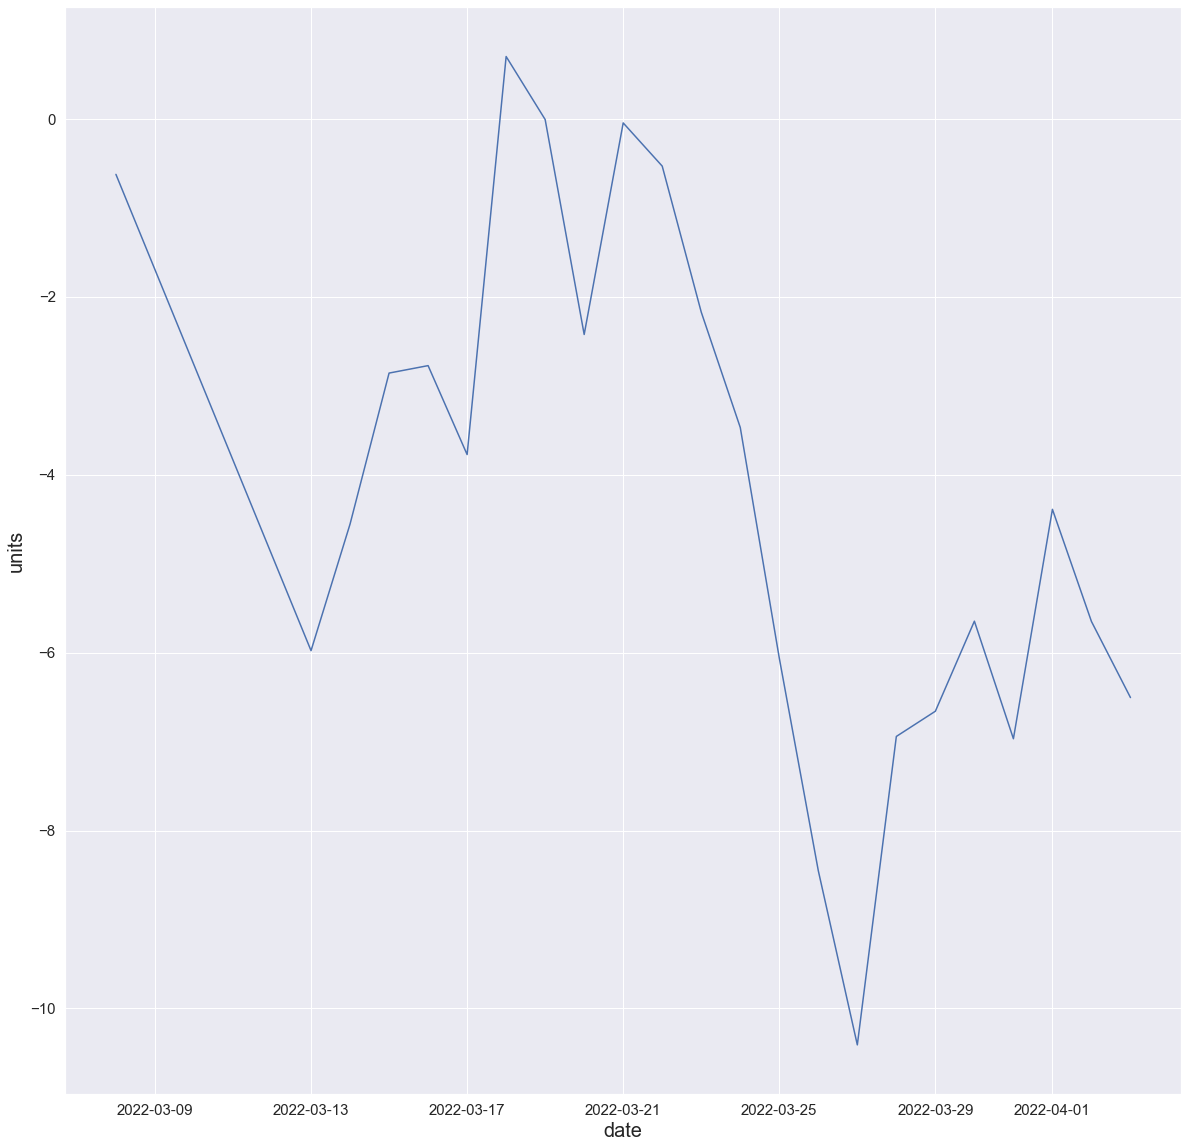

In [9]:
# seaborn formatting
sns.set(rc={"figure.figsize":(20, 20)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

sns.lineplot(data=algo_df.groupby(['date']).sum(), x='date', y=algo_df.groupby(['date']).sum()['profit'].cumsum())

# Total
totals = {'model': ['algorithmic'], 'record': [], 'accuracy': [], 'profit': []}

profit = algo_df['profit'].sum()
correct = algo_df[algo_df['hit'] == True]['hit'].count()
wrong = algo_df[algo_df['hit'] == False]['hit'].count()

totals['record'].append(f'{correct} - {wrong}')
totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
totals['profit'].append(round(profit, 2))

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals

## Make picks

In [10]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
today_df['profit'] = 0
today_df['accuracy'] = 0
today_df['count'] = 0
for model in models:
    # Differential profit and accuarcy
    temp = df.groupby([model + '_diff'])[[model + '_hit', model + '_profit']].aggregate(['sum', 'count'])
    temp['accuracy'] = round(temp[(model + '_hit', 'sum')] / temp[(model + '_hit', 'count')] * 100)
    temp['profit'] = round(temp[(model + '_profit', 'sum')], 2)
    temp['count'] = temp[(model + '_hit', 'count')]
    temp = temp.reset_index()
    temp.columns = [col[0] for col in temp.columns]
    temp = temp[[model + '_diff', 'accuracy', 'profit', 'count']]

    # Compute difference between line and prediction
    today_df[model + '_diff'] = myround(today_df[model] - today_df['line'])
    
    # Merge differential's profit and accuracy
    today_df = pd.merge(today_df, temp, left_on = [model + '_diff'], right_on=[model + '_diff'], how='left', suffixes=('', '_' + model))

In [11]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']

# Expected profit
for model in models:
    today_df[model + '_expected_profit'] = today_df['profit_' + model] * today_df['accuracy_' + model]

# Find model with max expected profit
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
models = [model + '_expected_profit' for model in models]

today_df = today_df.fillna(0)

today_df['total_expected_profit'] = \
            today_df['linear_expected_profit'] + today_df['decision_tree_expected_profit'] + \
            today_df['gradient_boosted_expected_profit'] + today_df['neural_network_expected_profit'] + \
            today_df['random_forest_expected_profit'] + today_df['avg_expected_profit']

today_df['max_expected_profit'] = today_df[models].idxmax(axis=1)
today_df['max_expected_profit'] = today_df['max_expected_profit'].apply(lambda x: '_'.join(x.split('_')[:-2]))

# Predictions for models that result in max expected profit
predictions = []
for index, row in today_df.iterrows():
    model = row['max_expected_profit']
    predictions.append(row[model])

today_df['prediction'] = predictions
today_df['over_under'] = np.where(today_df['prediction'] > today_df['line'], 'o', 'u')

In [12]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
expected_profits = [model + '_expected_profit' for model in models]

for model in models:
    today_df[model] = np.where(today_df[model] > today_df['line'], 'o', 'u')

cols = ['date', 'visitor', 'home', 'line'] + ['total_expected_profit', 'max_expected_profit'] + models + expected_profits
today_df[cols].sort_values(['total_expected_profit'], ascending=False)

,date,visitor,home,line,total_expected_profit,max_expected_profit,linear,decision_tree,gradient_boosted,neural_network,random_forest,avg,linear_expected_profit,decision_tree_expected_profit,gradient_boosted_expected_profit,neural_network_expected_profit,random_forest_expected_profit,avg_expected_profit


In [13]:
today_df[['date', 'visitor', 'home', 'random_forest', 'line', 'over', 'under']].tail(today_df.shape[0])

,date,visitor,home,random_forest,line,over,under


In [14]:
today_df = today_df[['date', 'visitor', 'home', 'over_under', 'prediction', 'line', 'over', 'under']]
algo_predictions = pd.read_csv('backend/predictions/3p_predictions_algo.csv').drop(['Unnamed: 0'], axis=1)
algo_predictions = algo_predictions.append(today_df, ignore_index=True)
algo_predictions['date'] = pd.to_datetime(algo_predictions['date'])
algo_predictions = algo_predictions.drop_duplicates(['date', 'home', 'visitor'])
algo_predictions.to_csv('backend/predictions/3p_predictions_algo.csv')